In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from scipy.optimize import minimize
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools

In [2]:
# Import data
amd = pd.read_csv('AMD.csv', header=0, index_col='Date', parse_dates=True)

Text(0.5, 1.0, 'AMD Autocorrelation plot')

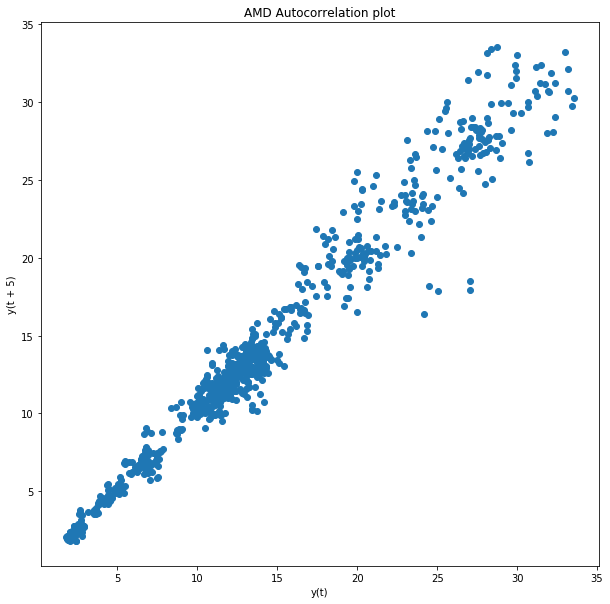

In [3]:
plt.figure(figsize=(10,10))
lag_plot(amd['Open'], lag=5)
plt.title('AMD Autocorrelation plot')

C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


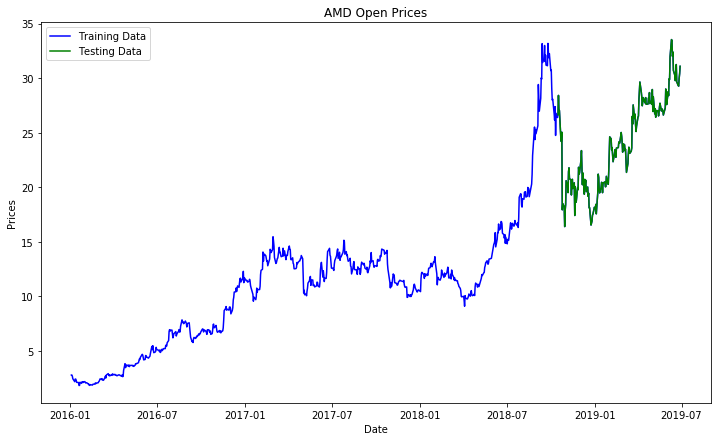

In [4]:
train_data, test_data = amd[0:int(len(amd)*0.8)], amd[int(len(amd)*0.8):]
plt.figure(figsize=(12,7))
plt.title('AMD Open Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(amd['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
#plt.xticks(np.arange(0,7982, 1300), amd['Date'][0:7982:1300])
plt.legend()

In [5]:
y = amd['Close'].resample('MS').mean()

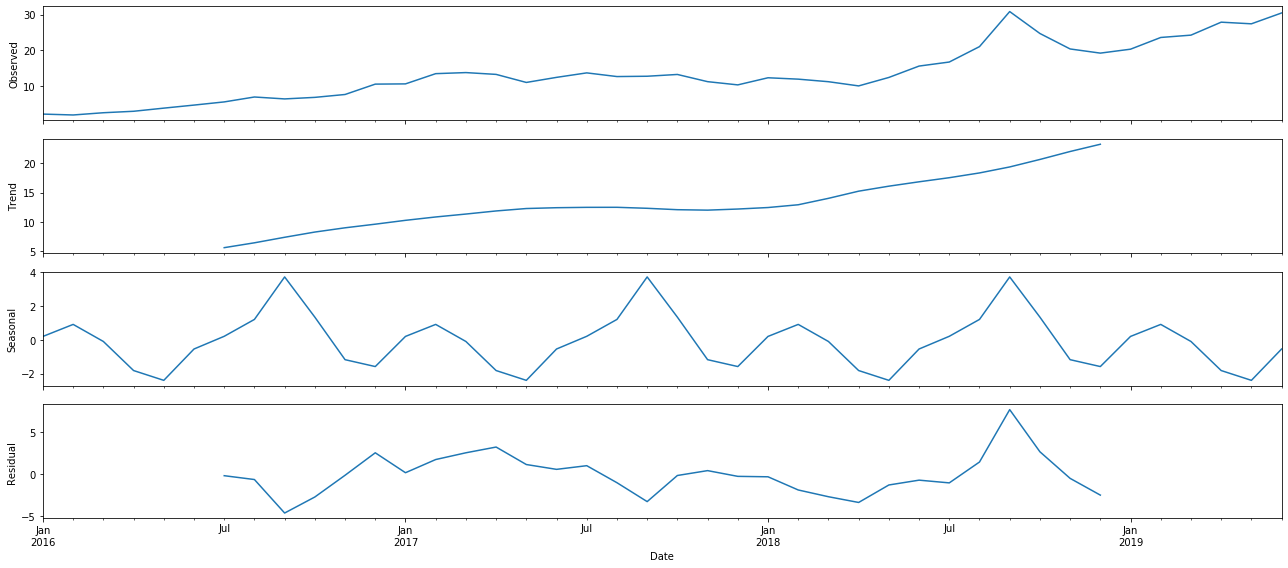

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

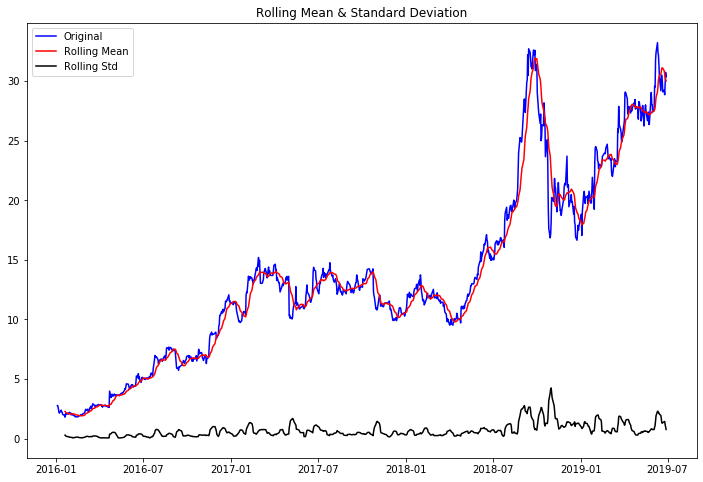

Results of Dickey-Fuller Test:
p-value = 0.7302. The series is likely non-stationary.
Test Statistic                  -1.061323
p-value                          0.730247
#Lags Used                      18.000000
Number of Observations Used    859.000000
Critical Value (1%)             -3.437986
Critical Value (5%)             -2.864911
Critical Value (10%)            -2.568565
dtype: float64


In [8]:
test_stationarity(amd['Close'])

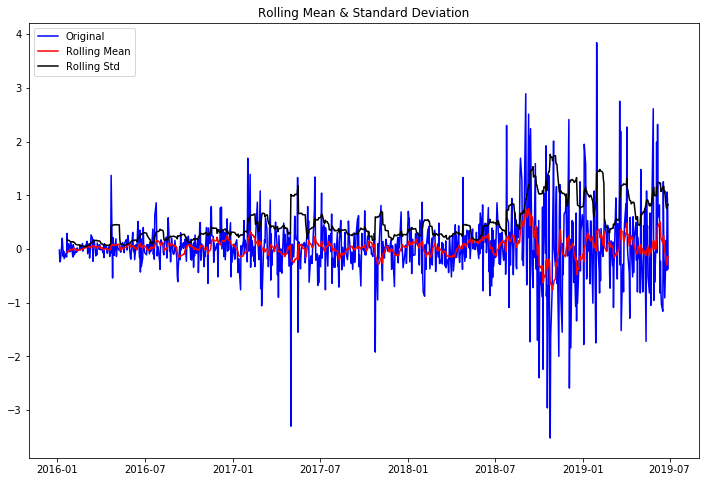

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.749509e+00
p-value                        6.012074e-07
#Lags Used                     1.700000e+01
Number of Observations Used    8.590000e+02
Critical Value (1%)           -3.437986e+00
Critical Value (5%)           -2.864911e+00
Critical Value (10%)          -2.568565e+00
dtype: float64


In [9]:
first_diff = amd['Close'] - amd['Close'].shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

In [10]:
amd['first_diff'] = first_diff

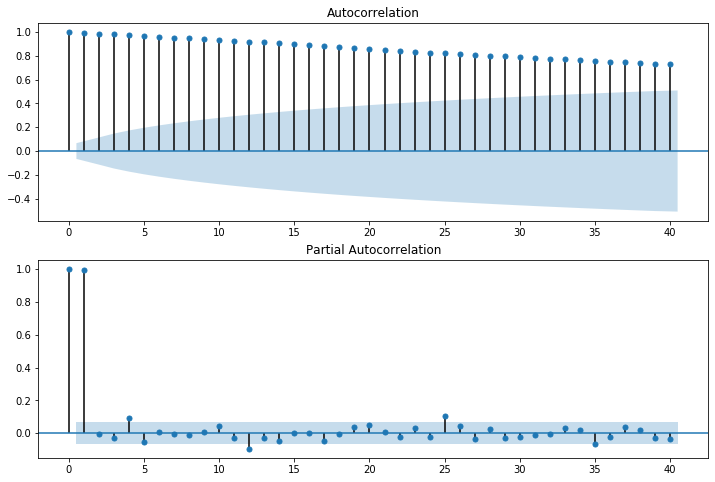

In [11]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(amd['Close'], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(amd['Close'], lags=40, ax=ax2)# , lags=40

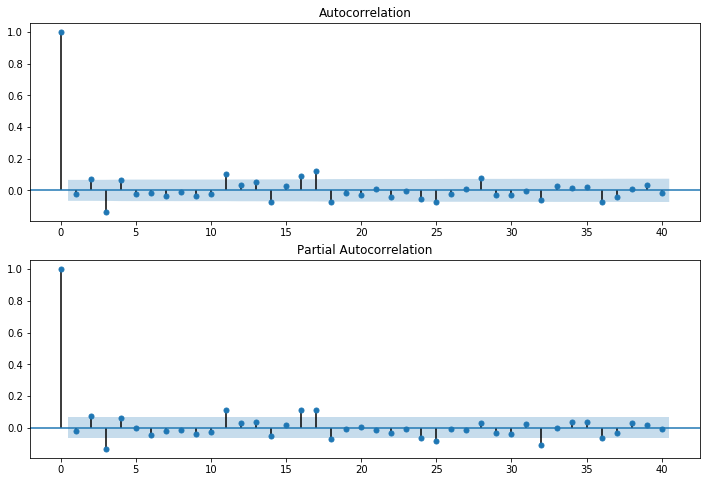

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

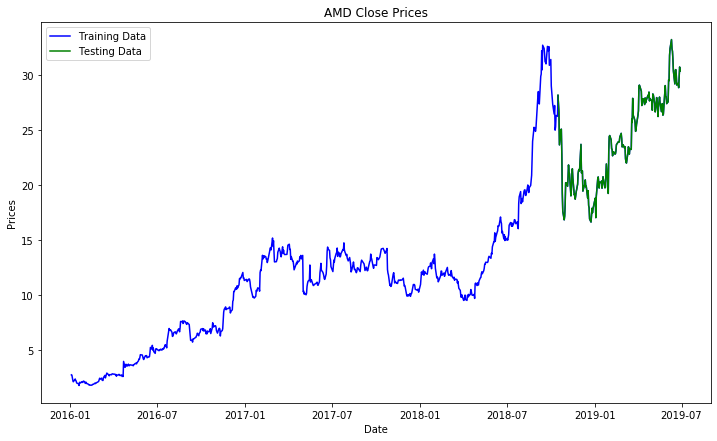

In [13]:
plt.figure(figsize=(12,7))
plt.title('AMD Close Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(amd['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
#plt.xticks(np.arange(0,7982, 1300), amd['Date'][0:7982:1300])
plt.legend()

In [14]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [15]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>


C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\pp186c\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:

Testing Mean Squared Error: 1.063
Symmetric mean absolute percentage error: 19.231


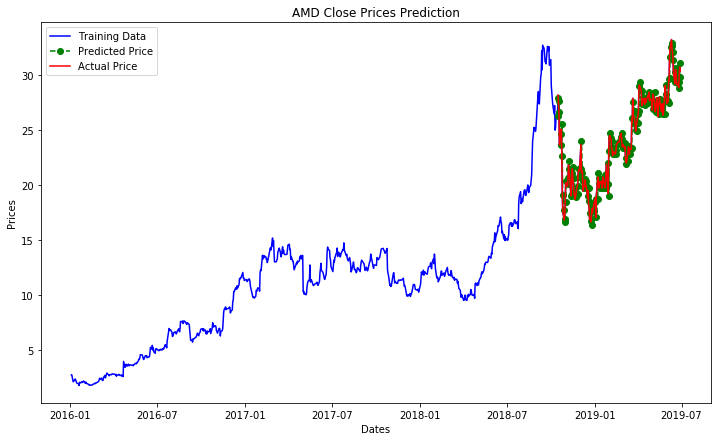

In [16]:
plt.figure(figsize=(12,7))
plt.plot(amd['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('AMD Close Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

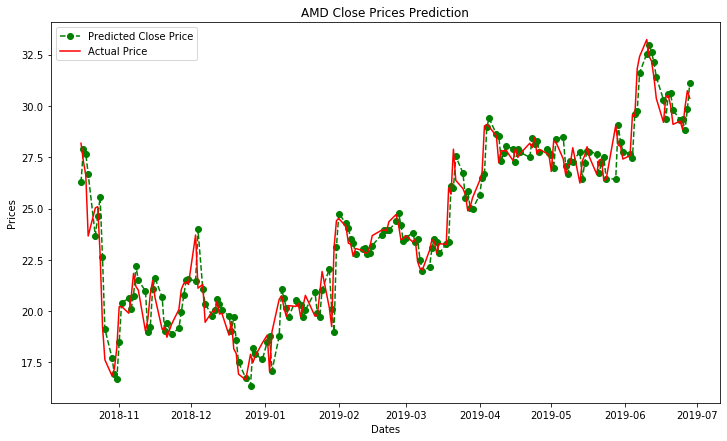

In [17]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Close Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.legend()
plt.title('AMD Close Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(6386,7982, 300), df['Date'][6386:7982:300])
plt.legend()

In [19]:
predictions

[array([26.27902475]),
 array([27.88088482]),
 array([27.67780148]),
 array([26.66764898]),
 array([23.6802912]),
 array([24.61765183]),
 array([25.54294099]),
 array([22.62851934]),
 array([19.13446122]),
 array([17.71143141]),
 array([16.9337928]),
 array([16.68177185]),
 array([18.49897483]),
 array([20.41580006]),
 array([20.61800443]),
 array([20.12848694]),
 array([20.72295131]),
 array([22.19653376]),
 array([21.50656714]),
 array([20.98014369]),
 array([18.98509674]),
 array([19.21025195]),
 array([21.10153425]),
 array([21.60777301]),
 array([20.68056285]),
 array([19.03882122]),
 array([19.44375463]),
 array([18.88485502]),
 array([19.16679475]),
 array([19.95413417]),
 array([20.76452341]),
 array([21.497126]),
 array([21.58243648]),
 array([21.45411541]),
 array([23.97799065]),
 array([21.09548041]),
 array([20.34444503]),
 array([19.78264759]),
 array([20.06546982]),
 array([20.58590176]),
 array([20.34687731]),
 array([20.03618997]),
 array([19.78600211]),
 array([19.0380